In [1]:
import pandas as pd
import sys
import os.path as op 
from numpy.linalg import norm
from gensim.models import FastText
import numpy as np


basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import tweet_vectorizer

from preprocess import Preprocess
prep = Preprocess()

        
def preprocess_tweet(tweet):
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete")
    tweet = prep.remove_repeating_characters(tweet)
    tweet = prep.remove_repeating_words(tweet)
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)
    tweet = prep.to_lowercase(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet)
    tweet = prep.remove_stopwords(tweet, include_personal_words=False, include_negations=False)
    tweet = [word for word in tweet if word not in ["diabetes", "diabetic"]]
    return tweet

def cosinus_similarity(a, b):
    return np.inner(a,b)/(norm(a)*norm(b))

model = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")

data = pd.read_parquet("Tweets_groupLabel_20190715.parquet")
data["text_vec"] = data.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model))

data.head()

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!


,id,text,user_name,gender,typeDiabetes,geo_adm1_code,geo_name,user_location,place_full_name,label,text_vec
0,1.129140e+18,When I was initially diagnosed with #type2diab...,Lynda Jimenez,1,1,AZ,Phoenix,"Phoenix, AZ",None,4,"[0.091667205, 0.032091808, -0.081855804, -0.07..."
1,1.102559e+18,Later Twitter it's back to sleep for a nap wok...,Deanna Porter Weick,0,0,MI,Monroe,"Monroe, MI",None,11,"[0.16888438, -0.029450605, 0.0862785, -0.06317..."
2,1.039046e+18,Ugh not ready for this 3hour glucose test tomo...,Esmeralda,2,0,CA,Hemet,Hemet CA,None,22,"[0.07679383, -0.038904045, 0.13049835, -0.2382..."
3,9.581800e+17,@hotfunkytown They also lock up diabetic suppl...,Joyce Pride,0,0,MO,Maryville,"Maryville, Missouri",None,3,"[0.12150481, 0.11272085, 0.11174324, -0.108990..."
4,9.151822e+17,@I_TheeWed “Hey mom! I know you’re dreading th...,Hot Mess Momma🍁,2,0,OK,Oklahoma City,Illinois ✈️ Oklahoma,None,3,"[0.06801716, 0.14217816, 0.018431958, -0.32431..."


In [2]:
def get_groupCenter(group, vectorColumn="text_vec"):
    matrix_form = np.asarray(group[vectorColumn].values.tolist())
    groupCenter = np.sum(matrix_form,axis=0) / matrix_form.shape[0]
    
    #group["cos_similarity_to_center"] = group["text_vec"].map(lambda vec: cosinus_similarity(vec, groupCenter))
    #group.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    #print(type(groupCenter), groupCenter.shape)
    return(groupCenter)


dataCenters = data.groupby(by="label", as_index=False) \
              .apply(lambda group: get_groupCenter(group, "text_vec")) \
              .reset_index(drop=True)

print(dataCenters.shape, type(dataCenters))

(30,) <class 'pandas.core.series.Series'>


In [3]:
data.shape

(46407, 11)

In [4]:

#cosine_sim_matrix = pd.DataFrame(columns=[topic_labels[i] for i in range(0,30)])#columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9",
#                                         "c10", "c11", "c12", "c13", "c14", "c15", "c16", "c17", "c18", "c19",
#                                         "c20", "c21", "c22", "c23", "c24", "c25", "c26", "c27", "c28", "c29"])

cosine_sim_matrix = np.zeros((data.shape[0], 30))
for i, row in data.iterrows():
    for j, center in enumerate(dataCenters):
        #print("i:", i, " j:", j)
        cosine_sim_matrix[i, j] = cosinus_similarity(row["text_vec"], center)
        
    if i % 5000 == 0 :
        print(i)

print(cosine_sim_matrix.shape)

0


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


5000
10000
15000
20000
25000
30000
35000
40000
45000
(46407, 30)


In [49]:

topic_labels = {0:"DSMA_support_3", 1: "Diabetes_popstar_Nick_Jonas", 2:"Insulin_(access)", 3:"Negative_feelings_diabetes",
                4:"Diaversary", 5:"Misunderstandings_diabetes", 6:"Living_with_T1D", 7:"Access_insulin_insulinPrice",
                8:"Diagnosis", 9:"Inspiring_relatives_living_with_diabetes_Support", 10:"insulin pump",
                11:"Information_diabetes-rel_events_of_the_day", 12:"Bloodsugar_palette_(beauty products)",
                13:"Inspiring_relatives_living_with_diabetes", 14:"Glucose_guardian", 15:"T1D",
                16:"DiabetesAwareness_Support_Donation", 17:"Glucosevariability", 18:"Diabetes_comorbidities",
                19:"Chronic_diseases_diabetes_comorbidities", 20:"DSMA_support_4", 21:"Confusion_between_T1D_and_T2D",
                22:"OGTT", 23:"DSMA_support_2", 24:"Diabetes_care", 25:"DSMA_support_1", 26:"Diabetes_and_entourage_1",
                27:"Life_with_and_without_diabetes", 28:"Diabetes_and_entourage_2", 29:"Insulin_use"}

topic_level1_labels = {
            0:"Diabetes online support", 1:"Miscellenous", 2:"Insulin", 3:"Feelings", 4:"Diabetes", 5:"Feelings", 
            6:"Life with diabetes", 7:"Insulin", 8:"Diabetes", 9:"Entourage", 10:"Insulin", 11:"Diabetes",
            12:"Miscellaneous", 13:"Entourage", 14:"Healthcare", 15:"Diabetes", 16:"Diabetes online support",
            17:"Diabetes", 18:"Diab-rel complications", 19:"Diab-rel complications",
            20:"Diabetes online support", 21:"Diabetes", 22:"OGTT", 23:"Diabetes online support",
            24:"Diabetes", 25:"Diabetes online support", 26:"Entourage", 27:"Life with diabetes",
            28:"Entourage", 29:"Insulin"}


tuples = list(zip([topic_level1_labels[i] for i in range(0, 30)], [topic_labels[i] for i in range(0, 30)]))
index = pd.MultiIndex.from_tuples(tuples, names=['Level1_topics', 'topics'])
#cosine_sim_matrix_pd = pd.DataFrame(cosine_sim_matrix, columns=[topic_labels[i] for i in range(0, 30)])
cosine_sim_matrix_pd = pd.DataFrame(cosine_sim_matrix, columns=index)
cosine_sim_matrix_pd.head()


Level1_topics,Diabetes online support,Miscellenous,Insulin,Feelings,Diabetes,Feelings,Life with diabetes,Insulin,Diabetes,Entourage,...,Diabetes online support,Diabetes,OGTT,Diabetes online support,Diabetes,Diabetes online support,Entourage,Life with diabetes,Entourage,Insulin
topics,DSMA_support_3,Diabetes_popstar_Nick_Jonas,Insulin_(access),Negative_feelings_diabetes,Diaversary,Misunderstandings_diabetes,Living_with_T1D,Access_insulin_insulinPrice,Diagnosis,Inspiring_relatives_living_with_diabetes_Support,...,DSMA_support_4,Confusion_between_T1D_and_T2D,OGTT,DSMA_support_2,Diabetes_care,DSMA_support_1,Diabetes_and_entourage_1,Life_with_and_without_diabetes,Diabetes_and_entourage_2,Insulin_use
0,0.791282,0.669108,0.722288,0.789422,0.897179,0.809238,0.784572,0.781562,0.875914,0.774045,...,0.798114,0.821806,0.705209,0.716898,0.777958,0.748924,0.786805,0.802394,0.823877,0.792698
1,0.777779,0.677034,0.714431,0.788249,0.788799,0.762542,0.766696,0.745560,0.766136,0.754690,...,0.823362,0.752624,0.772959,0.771036,0.757685,0.760285,0.749965,0.766812,0.804816,0.777757
2,0.725706,0.619255,0.644885,0.728903,0.691606,0.683046,0.727878,0.674981,0.673058,0.699553,...,0.746364,0.678024,0.910151,0.709898,0.684963,0.707004,0.673459,0.687651,0.699387,0.714653
3,0.780250,0.639622,0.778312,0.825264,0.741734,0.814218,0.798327,0.792016,0.745632,0.787514,...,0.814234,0.768517,0.696508,0.759176,0.794003,0.768892,0.749713,0.794803,0.780491,0.794746
4,0.826327,0.761986,0.760850,0.867632,0.811426,0.819195,0.799714,0.793929,0.811334,0.812940,...,0.853868,0.795667,0.854687,0.798708,0.781163,0.823555,0.784727,0.810683,0.838773,0.830035


In [50]:
cosine_sim_matrix_pd.sort_values(by="Level1_topics", ascending=True, axis=1, inplace=True)
cosine_sim_matrix_pd.head()

Level1_topics                  Diab-rel complications                         \
topics        Chronic_diseases_diabetes_comorbidities Diabetes_comorbidities   
0                                            0.754670               0.799564   
1                                            0.751750               0.780823   
2                                            0.653279               0.668633   
3                                            0.719558               0.772938   
4                                            0.751550               0.791156   

Level1_topics           Diabetes                                     \
topics        Glucosevariability       T1D Diaversary Diabetes_care   
0                       0.787499  0.633125   0.897179      0.777958   
1                       0.788522  0.644219   0.788799      0.757685   
2                       0.781498  0.633052   0.691606      0.684963   
3                       0.762014  0.695558   0.741734      0.794003   
4                       0.839059  0.668820   0.811426      0.781163   

Level1_topics                                                       \
topics        Information_diabetes-rel_events_of_the_day Diagnosis   
0                                               0.824847  0.875914   
1                                               0.834942  0.766136   
2                                               0.788727  0.673058   
3                                               0.776390  0.745632   
4                                               0.851447  0.811334   

Level1_topics                                \
topics        Confusion_between_T1D_and_T2D   
0                                  0.821806   
1                                  0.752624   
2                                  0.678024   
3                                  0.768517   
4                                  0.795667   

Level1_topics            Diabetes online support  ...       Healthcare  \
topics        DiabetesAwareness_Support_Donation  ... Glucose_guardian   
0                                       0.791326  ...         0.609760   
1                                       0.787132  ...         0.673363   
2                                       0.718917  ...         0.797180   
3                                       0.803927  ...         0.644892   
4                                       0.823605  ...         0.786011   

Level1_topics      Insulin                                               \
topics        insulin pump Access_insulin_insulinPrice Insulin_(access)   
0                 0.761099                    0.781562         0.722288   
1                 0.779850                    0.745560         0.714431   
2                 0.725273                    0.674981         0.644885   
3                 0.765765                    0.792016         0.778312   
4                 0.825038                    0.793929         0.760850   

Level1_topics             Life with diabetes                                 \
topics        Insulin_use    Living_with_T1D Life_with_and_without_diabetes   
0                0.792698           0.784572                       0.802394   
1                0.777757           0.766696                       0.766812   
2                0.714653           0.727878                       0.687651   
3                0.794746           0.798327                       0.794803   
4                0.830035           0.799714                       0.810683   

Level1_topics                        Miscellaneous  \
topics        Bloodsugar_palette_(beauty products)   
0                                         0.675697   
1                                         0.692485   
2                                         0.709737   
3                                         0.679626   
4                                         0.757357   

Level1_topics                Miscellenous      OGTT  
topics        Diabetes_popstar_Nick_Jonas      OGTT  
0                                0

In [51]:
corr = cosine_sim_matrix_pd.corr(method="spearman")
corr.head()

Level1_topics                                                                   Diab-rel complications  \
topics                                                         Chronic_diseases_diabetes_comorbidities   
Level1_topics          topics                                                                            
Diab-rel complications Chronic_diseases_diabetes_comorbidities                                1.000000   
                       Diabetes_comorbidities                                                 0.790589   
Diabetes               Glucosevariability                                                     0.776005   
                       T1D                                                                    0.240057   
                       Diaversary                                                             0.828493   

Level1_topics                                                                          \
topics                                                         Diabetes_comorbidities   
Level1_topics          topics                                                           
Diab-rel complications Chronic_diseases_diabetes_comorbidities               0.790589   
                       Diabetes_comorbidities                                1.000000   
Diabetes               Glucosevariability                                    0.813644   
                       T1D                                                   0.105155   
                       Diaversary                                            0.764983   

Level1_topics                                                            Diabetes  \
topics                                                         Glucosevariability   
Level1_topics          topics                                                       
Diab-rel complications Chronic_diseases_diabetes_comorbidities           0.776005   
                       Diabetes_comorbidities                            0.813644   
Diabetes               Glucosevariability                                1.000000   
                       T1D                                               0.211934   
                       Diaversary                                        0.732933   

Level1_topics                                                             \
topics                                                               T1D   
Level1_topics          topics                                              
Diab-rel complications Chronic_diseases_diabetes_comorbidities  0.240057   
                       Diabetes_comorbidities                   0.105155   
Diabetes               Glucosevariability                       0.211934   
                       T1D                                      1.000000   
                       Diaversary                               0.300479   

Level1_topics                                                              \
topics                                                         Diaversary   
Level1_topics          topics                                               
Diab-rel complications Chronic_diseases_diabetes_comorbidities   0.828493   
                       Diabetes_comorbidities                    0.764983   
Diabetes               Glucosevariability                        0.732933   
                       T1D                                       0.300479   
                       Diaversary                                1.000000   

Level1_topics                                                                 \
topics                                                         Diabetes_care   
Level1_topics          topics                                                  
Diab-rel complications Chronic_diseases_diabetes_comorbidities      0.807244   
                       Diabetes_comorbidities                       0.817215   
Diabetes               Glucosevariability                           0.752760   
                       T1D                         

In [52]:
labels = [a+"__"+b for a, b in list(zip(corr.columns.get_level_values(level=0), corr.columns.get_level_values(level=1)))]
corr.columns = labels
corr.index = labels
corr.head()

,Diab-rel complications__Chronic_diseases_diabetes_comorbidities,Diab-rel complications__Diabetes_comorbidities,Diabetes__Glucosevariability,Diabetes__T1D,Diabetes__Diaversary,Diabetes__Diabetes_care,Diabetes__Information_diabetes-rel_events_of_the_day,Diabetes__Diagnosis,Diabetes__Confusion_between_T1D_and_T2D,Diabetes online support__DiabetesAwareness_Support_Donation,...,Healthcare__Glucose_guardian,Insulin__insulin pump,Insulin__Access_insulin_insulinPrice,Insulin__Insulin_(access),Insulin__Insulin_use,Life with diabetes__Living_with_T1D,Life with diabetes__Life_with_and_without_diabetes,Miscellaneous__Bloodsugar_palette_(beauty products),Miscellenous__Diabetes_popstar_Nick_Jonas,OGTT__OGTT
Diab-rel complications__Chronic_diseases_diabetes_comorbidities,1.000000,0.790589,0.776005,0.240057,0.828493,0.807244,0.873285,0.812810,0.814032,0.788658,...,0.569259,0.813085,0.795084,0.633959,0.852697,0.652943,0.856334,0.518047,0.790748,0.665700
Diab-rel complications__Diabetes_comorbidities,0.790589,1.000000,0.813644,0.105155,0.764983,0.817215,0.750797,0.775012,0.860356,0.702805,...,0.487018,0.648367,0.709344,0.497720,0.789040,0.559737,0.799338,0.365797,0.634972,0.586977
Diabetes__Glucosevariability,0.776005,0.813644,1.000000,0.211934,0.732933,0.752760,0.852417,0.674755,0.765529,0.696052,...,0.803630,0.751420,0.702365,0.503474,0.826335,0.639237,0.763497,0.592281,0.590588,0.869822
Diabetes__T1D,0.240057,0.105155,0.211934,1.000000,0.300479,0.207102,0.385701,0.308551,0.246398,0.448919,...,0.204932,0.224410,0.135821,0.543426,0.164452,0.792139,0.276828,0.673717,0.352224,0.200126
Diabetes__Diaversary,0.828493,0.764983,0.732933,0.300479,1.000000,0.788008,0.899999,0.964027,0.886853,0.793888,...,0.459710,0.698802,0.720920,0.596267,0.750070,0.692458,0.803594,0.520923,0.772327,0.637129


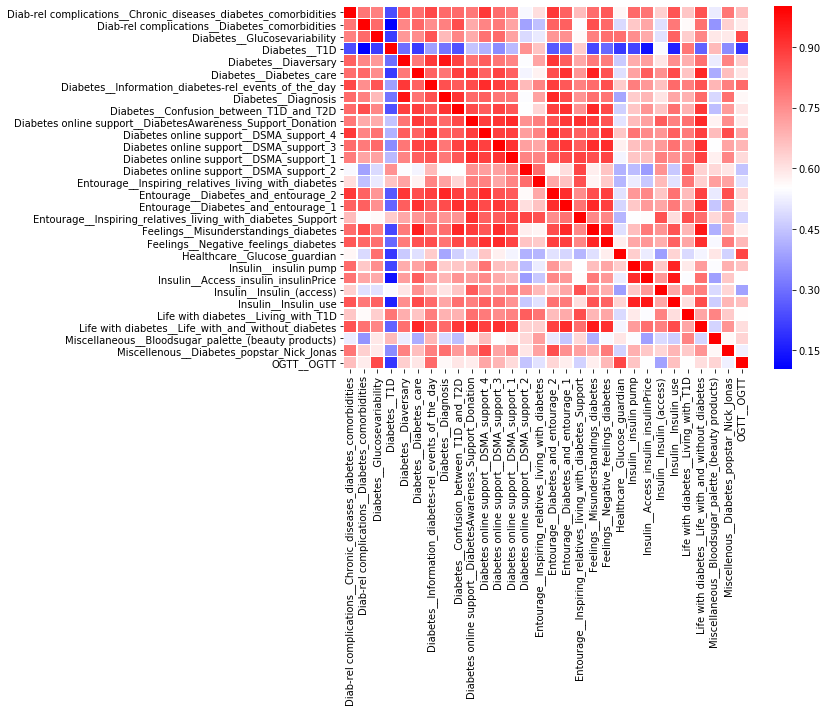

In [61]:
# Draw correlation plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.heatmap(corr,  linewidths=.5, ax=ax, cmap="bwr")
#ax = sns.heatmap(corr, cmap="bwr")
plt.tight_layout()
plt.savefig("correlation_plot_20190723.png")


'\nAccent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, \nGnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r,\nPastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, \nPurples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, \nSet1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r,\nYlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, \nbwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag,\nflag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, \ngist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gn

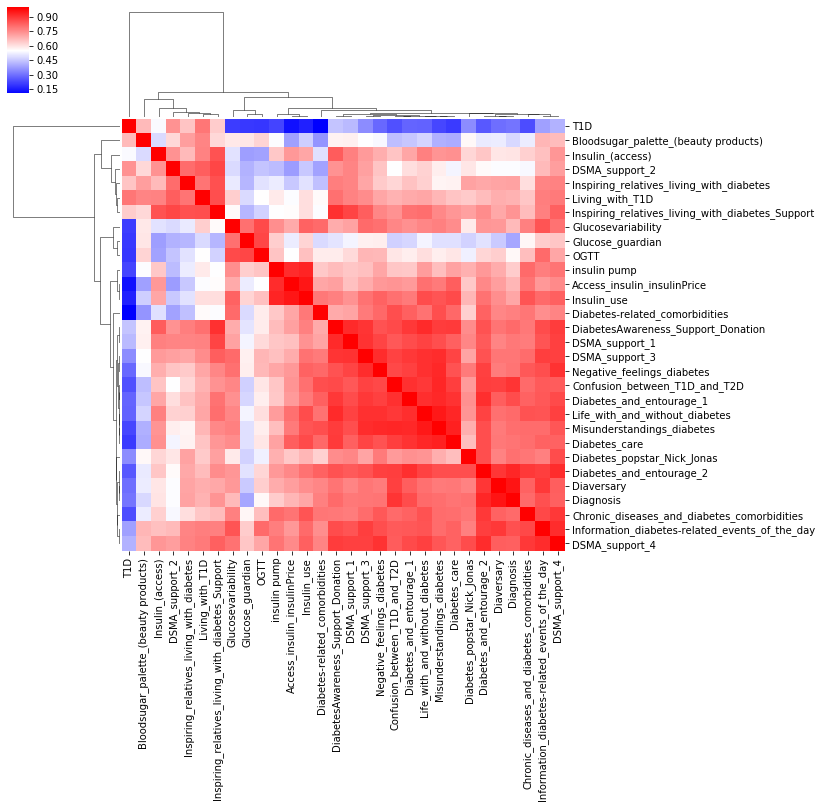

In [7]:
import seaborn as sns
%matplotlib inline
sns.clustermap(corr, metric="cosine", method='average', cmap="bwr") # coolwarm, inferno_r

"""
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, 
GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r,
Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, 
Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, 
Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r,
YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, 
bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag,
flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, 
gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r,
gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma,
magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, 
prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10,
tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, 
twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r
"""